# Image processing with convolutions

## Imports

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datasets import load_dataset
from PIL import Image
import imageio as iio

## Loading in the data

In [ ]:
mnist = load_dataset("ylecun/mnist")

train = mnist["train"]
test  = mnist["test"]

c:\Users\asale\Manim snippets\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\asale\Manim snippets\.venv\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\asale\.cache\huggingface\hub\datasets--ylecun--mnist. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer m

In [10]:
X_train = np.stack([np.array(ex["image"]) for ex in train])
y_train = np.array([ex["label"] for ex in train])

X_test  = np.stack([np.array(ex["image"]) for ex in test])
y_test  = np.array([ex["label"] for ex in test])

print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


We can access the greyscale pixel values that make up any individual image. The values range from 0 to 255, where 0 is full black and 255 is full white.

In [33]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

We can also plot the raw images to see what they look like:

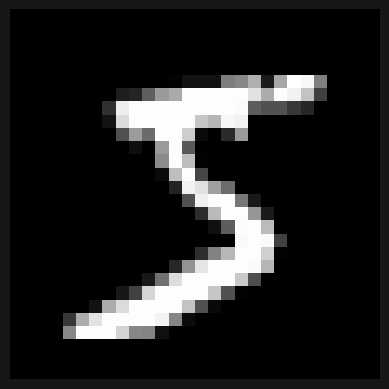

5


In [75]:
# Set background to match dark theme
plt.figure(facecolor='#161718')

# Set text and bar edges to white for readability
params = {"ytick.color" : "w",
        "xtick.color" : "w",
        "axes.labelcolor" : "#161718",
        "axes.edgecolor" : "#161718"}
plt.rcParams.update(params)

plt.imshow(X_train[0], cmap='gray')
plt.axis('off')
plt.show()
print(y_train[0])

Here is a comparison between what we (humans) can see and what the computer sees:

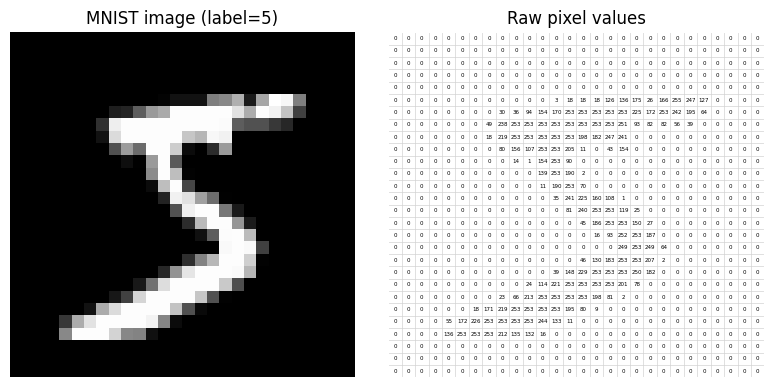

In [72]:
img = X_train[0].astype(int)  # Raw integers

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Left: normal image
axes[0].imshow(img, cmap="gray", vmin=0, vmax=255)
axes[0].set_title(f"MNIST image (label={y_train[0]})")
axes[0].axis("off")

# Right: raw integer grid only
ax = axes[1]
ax.set_xlim(-0.5, 27.5)
ax.set_ylim(27.5, -0.5)   # invert y so row 0 is at top like the image
ax.set_xticks(np.arange(-0.5, 28, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 28, 1), minor=True)
ax.grid(which="minor", color="lightgray", linestyle='-', linewidth=0.5)
ax.set_xticks([]); ax.set_yticks([])
ax.set_facecolor("white")
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        val = img[i, j]
        ax.text(j, i, f"{val}", ha="center", va="center", fontsize=4, color='black')

ax.set_title("Raw pixel values")
plt.tight_layout()
plt.show()

# Experimenting with convolutions

In [20]:
def single_convolution(image_subset, kernel):
    """
    Apply a kernel to an input image subset.
    """
    return np.sum(np.multiply(image_subset, kernel))

def convolution2d(image, kernel, stride=1, padding=0):
    """
    Apply a 2D convolution between the input image and kernel.
    This code provides a brute-force version of the computations.
    """
    # For general kernel size
    filter_height = kernel.shape[0]
    filter_width  = kernel.shape[1]
    
    # Prep output
    filtered_image = np.ndarray(shape=(image.shape[0] - filter_height + 1, 
                                       image.shape[1] - filter_width + 1))
    
    for row in range(filtered_image.shape[0]):
        for col in range(filtered_image.shape[1]):
            # Select next subset of image to convolve kernel with
            patch = image[row:(row + filter_height), 
                          col:(col + filter_width)]

            # Apply the convolution operation
            ms = single_convolution(patch, kernel)
            
            # store it at the right location
            filtered_image[row, col] = ms
            
    return filtered_image

In [44]:
# Verify code with an example
convolution2d(
    np.array([
        [2,5,6],
        [1,4,-3],
        [7,0,1]
    ]),

    np.array([
        [1,-1],
        [2,3]
    ])
)

array([[11., -2.],
       [11., 10.]])

In [69]:
def plot_conv_result(filtered_image):
    """
    Display the result of the convolution.
    """
    # Set background to match dark theme
    plt.figure(facecolor='#161718')
    
    # Set text and bar edges to white for readability
    params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
    plt.rcParams.update(params)
    
    im = plt.imshow(filtered_image, cmap='gray')
    plt.colorbar(im)
    plt.axis('off')
    plt.show()

## Prewitt kernels

In [70]:
kernel = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

# Convolve the kernel with the first MNIST image
filtered_image = convolution2d(X_train[0], kernel)

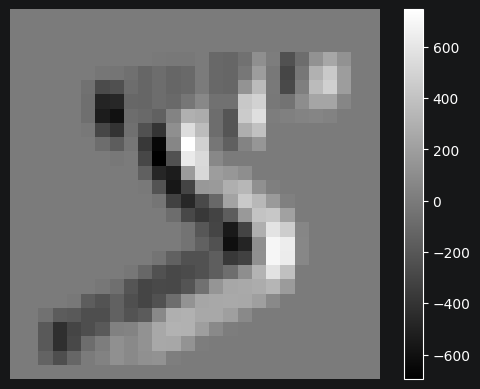

In [71]:
plot_conv_result(filtered_image)

This kernel seems to produce shadows on the left when there's a change from the black background to the white of a digit.

In [76]:
def apply_kernel(image, kernel):
    """
    Apply a kernel to an input image and return the filtered image.
    """
    filtered_image = convolution2d(image, kernel)
    plot_conv_result(filtered_image)

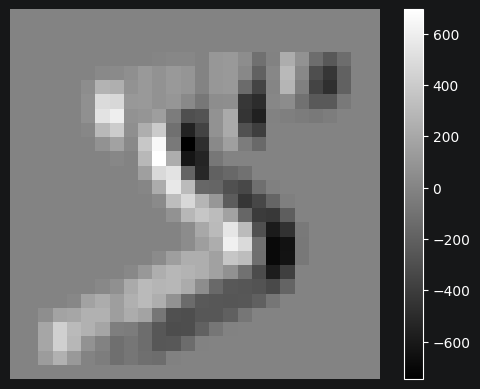

In [78]:
kernel = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])
apply_kernel(X_train[0], kernel)

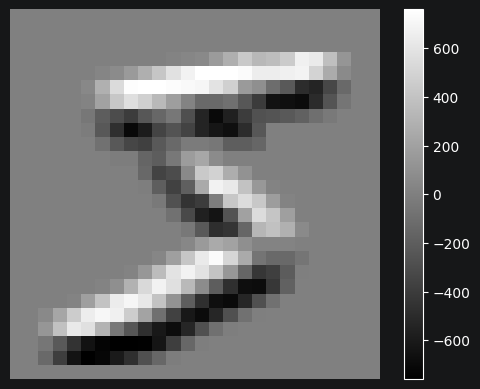

In [79]:
kernel = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
])
apply_kernel(X_train[0], kernel)

Different kernels will have different efficiencies depending on the input digit. For example, the filter that extracts horiontal lines could be more useful for the below '4' image than the above '5' image:

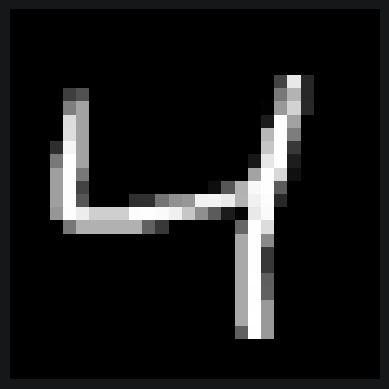

In [82]:
# Set background to match dark theme
plt.figure(facecolor='#161718')

# Set text and bar edges to white for readability
params = {"ytick.color" : "w",
        "xtick.color" : "w",
        "axes.labelcolor" : "#161718",
        "axes.edgecolor" : "#161718"}
plt.rcParams.update(params)

plt.imshow(X_train[2], cmap='gray')
plt.axis('off')
plt.show()

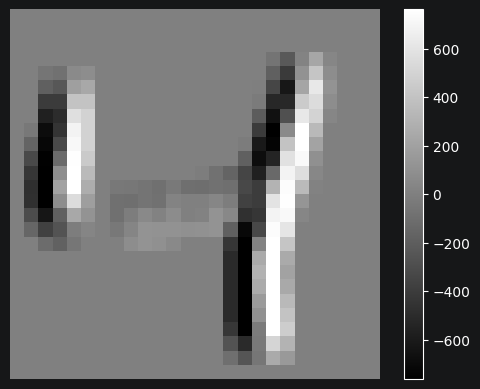

In [ ]:
kernel = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

apply_kernel(X_train[2], kernel)

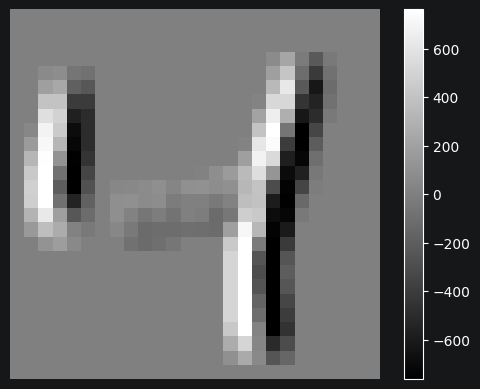

In [ ]:
kernel = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])

apply_kernel(X_train[2], kernel)

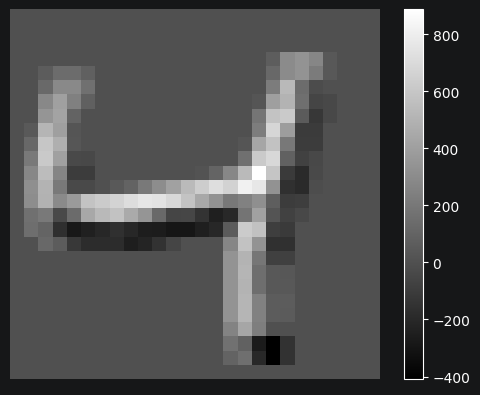

In [ ]:
kernel = np.array([
    [-1, -1, 1],
    [0, 0, 0],
    [1, 1, 1]
])

apply_kernel(X_train[2], kernel)

# Tiger image

C:\Users\asale\AppData\Local\Temp\ipykernel_10648\1695308155.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tiger = iio.imread('tiger.jpg')


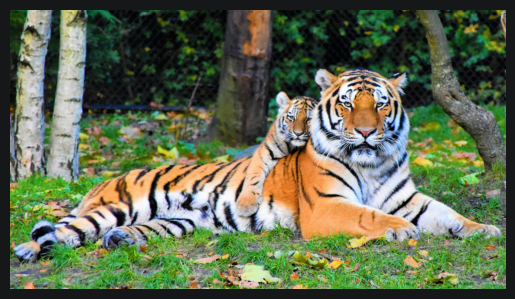

In [128]:
# Set background to match dark theme
plt.figure(facecolor='#161718')

tiger = iio.imread('tiger.jpg')

plt.imshow(tiger)#, cmap='gray')
plt.axis('off')
plt.show()

In [129]:
tiger = tiger.mean(axis=2)  # Convert to grayscale
tiger

array([[ 35.33333333,  31.33333333,  28.66666667, ...,  99.        ,
        106.        ,  99.66666667],
       [ 31.33333333,  31.33333333,  34.66666667, ...,  97.33333333,
        101.        ,  90.66666667],
       [ 27.33333333,  27.33333333,  30.66666667, ..., 100.33333333,
         99.33333333,  84.        ],
       ...,
       [104.        , 116.66666667, 135.33333333, ..., 125.33333333,
        104.66666667,  75.        ],
       [117.66666667, 129.66666667, 158.66666667, ..., 104.33333333,
         94.33333333,  89.        ],
       [132.        , 139.33333333, 174.33333333, ...,  88.        ,
         88.33333333, 101.        ]], shape=(2358, 4192))

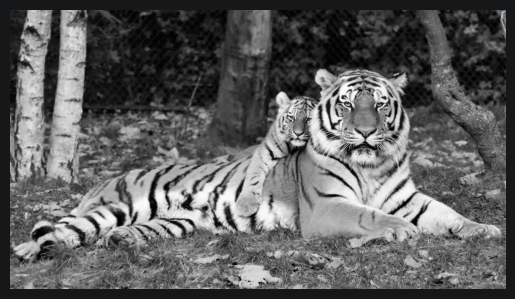

In [141]:
# Set background to match dark theme
plt.figure(facecolor='#161718')

plt.imshow(tiger, cmap='gray')
plt.axis('off')
plt.show()

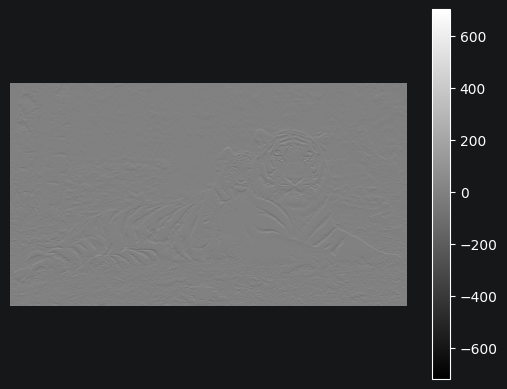

In [135]:
kernel = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
])

apply_kernel(tiger, kernel)

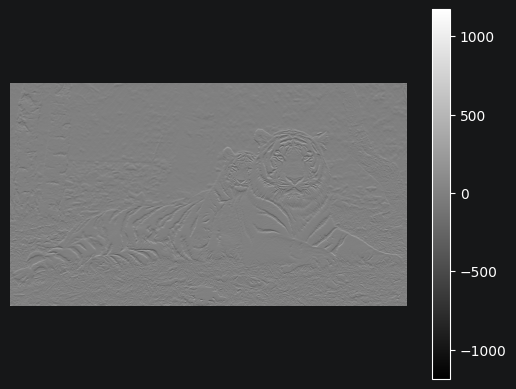

In [137]:
kernel = np.array([
    [-1,-1,-1,-1,-1],
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0],
    [1,1,1,1,1]
])

apply_kernel(tiger, kernel)

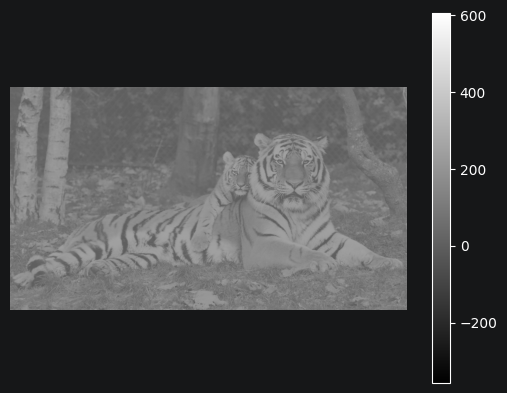

In [159]:
kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

apply_kernel(tiger, kernel)

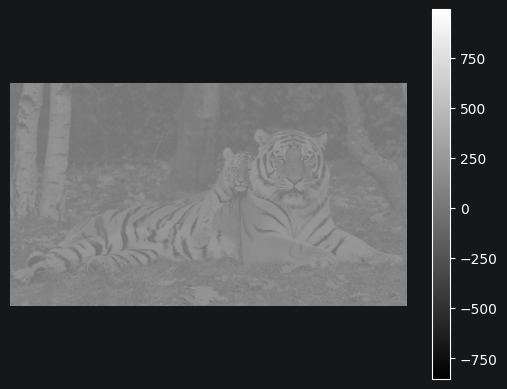

In [158]:
kernel = np.array([
    [-1, -1, -1],
    [-1, 9, -1],
    [-1, -1, -1]
])

apply_kernel(tiger, kernel)

## Gaussian filters (blurring)

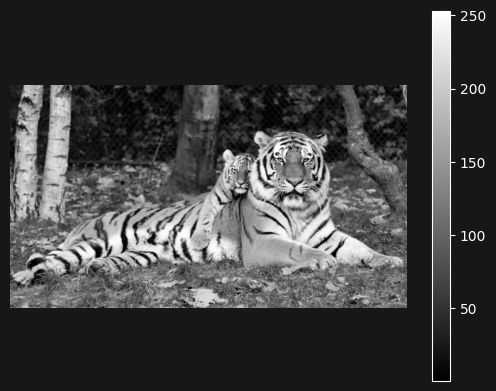

In [143]:
kernel = np.array([
    [1,4,7,4,1],
    [4,16,26,16,4],
    [7,26,41,26,7],
    [4,16,26,16,4],
    [1,4,7,4,1]
])
kernel = kernel / 273

apply_kernel(tiger, kernel)

It looks like the above kernel was not enough to achieve a strong enough blurring effect. In the following block, I resorted to scipy's `gaussian_filter` because my implementation took too long to run.
My initial filter attempt used a blurring kernel of size 25. The second attempt used a blurring kernel of size 49.

In [219]:
def gaussian_kernel(size, sigma):
    """Create a normalized 2D Gaussian kernel."""
    ax = np.arange(-size//2 + 1, size//2 + 1)
    x, y = np.meshgrid(ax, ax)
    kernel = np.exp(-(x**2+y**2) / (2.0*np.pi*sigma**2))
    kernel /= kernel.sum()
    return kernel

# Moderate blur
sigma = 4
kernel_size = int(6 * sigma + 1)

k = gaussian_kernel(kernel_size, sigma=sigma)
blur_conv = convolution2d(tiger, k)

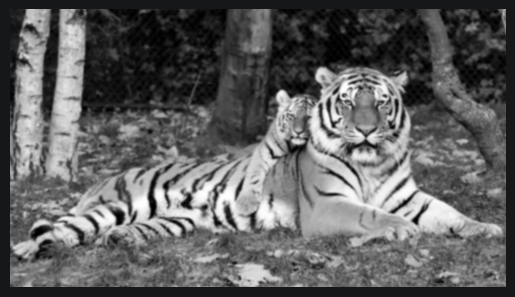

In [220]:
# Set background to match dark theme
plt.figure(facecolor='#161718')

# Set text and bar edges to white for readability
params = {"ytick.color" : "w",
        "xtick.color" : "w",
        "axes.labelcolor" : "w",
        "axes.edgecolor" : "w"}
plt.rcParams.update(params)

im = plt.imshow(blur_conv, cmap='gray')
plt.axis('off')
plt.show()

Second one (more blurring):

In [ ]:
# Moderate blur
sigma = 8
kernel_size = int(6 * sigma + 1)

k = gaussian_kernel(kernel_size, sigma=sigma)

In [213]:
k

array([[5.37643056e-05, 6.04302130e-05, 6.75856048e-05, ...,
        6.75856048e-05, 6.04302130e-05, 5.37643056e-05],
       [6.04302130e-05, 6.79225853e-05, 7.59651304e-05, ...,
        7.59651304e-05, 6.79225853e-05, 6.04302130e-05],
       [6.75856048e-05, 7.59651304e-05, 8.49599734e-05, ...,
        8.49599734e-05, 7.59651304e-05, 6.75856048e-05],
       ...,
       [6.75856048e-05, 7.59651304e-05, 8.49599734e-05, ...,
        8.49599734e-05, 7.59651304e-05, 6.75856048e-05],
       [6.04302130e-05, 6.79225853e-05, 7.59651304e-05, ...,
        7.59651304e-05, 6.79225853e-05, 6.04302130e-05],
       [5.37643056e-05, 6.04302130e-05, 6.75856048e-05, ...,
        6.75856048e-05, 6.04302130e-05, 5.37643056e-05]], shape=(49, 49))

In [214]:
blur_conv = convolution2d(tiger, k)

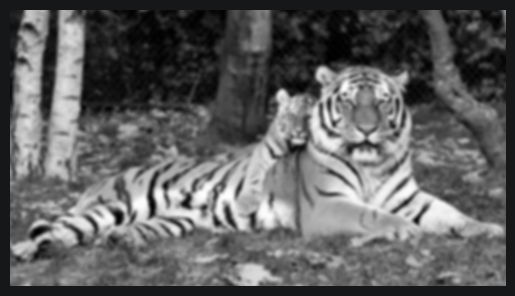

In [ ]:
# Set background to match dark theme
plt.figure(facecolor='#161718')

# Set text and bar edges to white for readability
params = {"ytick.color" : "w",
        "xtick.color" : "w",
        "axes.labelcolor" : "w",
        "axes.edgecolor" : "w"}
plt.rcParams.update(params)

im = plt.imshow(blur_conv, cmap='gray')
plt.axis('off')
plt.show()